## 1. Import Libraries and Setup

In [245]:

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, calinski_harabasz_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import matplotlib.image as mpimg

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline



## 2. Load and Explore Data

In [246]:
df = pd.read_csv('uber-data.csv')

print("Dataset Shape:", df.shape)
print("First few rows:")
print(df.head(10))
print("Data Types:")
print(df.dtypes)
print("Missing Values:")
print(df.isnull().sum())
print("Basic Statistics:")
print(df.describe())

Dataset Shape: (1028136, 4)
First few rows:
          Date/Time      Lat      Lon    Base
0  9/1/2014 0:01:00  40.2201 -74.0021  B02512
1  9/1/2014 0:01:00  40.7500 -74.0027  B02512
2  9/1/2014 0:03:00  40.7559 -73.9864  B02512
3  9/1/2014 0:06:00  40.7450 -73.9889  B02512
4  9/1/2014 0:11:00  40.8145 -73.9444  B02512
5  9/1/2014 0:12:00  40.6735 -73.9918  B02512
6  9/1/2014 0:15:00  40.7471 -73.6472  B02512
7  9/1/2014 0:16:00  40.6613 -74.2691  B02512
8  9/1/2014 0:32:00  40.3745 -73.9999  B02512
9  9/1/2014 0:33:00  40.7633 -73.9773  B02512
Data Types:
Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object
Missing Values:
Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64
Basic Statistics:
                Lat           Lon
count  1.028136e+06  1.028136e+06
mean   4.073922e+01 -7.397182e+01
std    4.082861e-02  5.831413e-02
min    3.998970e+01 -7.477360e+01
25%    4.072040e+01 -7.399620e+01
50%    4.074180e+01 -7.398310

In [280]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Hour'] = df['Date/Time'].dt.hour
df['DayOfWeekName'] = df['Date/Time'].dt.day_name()


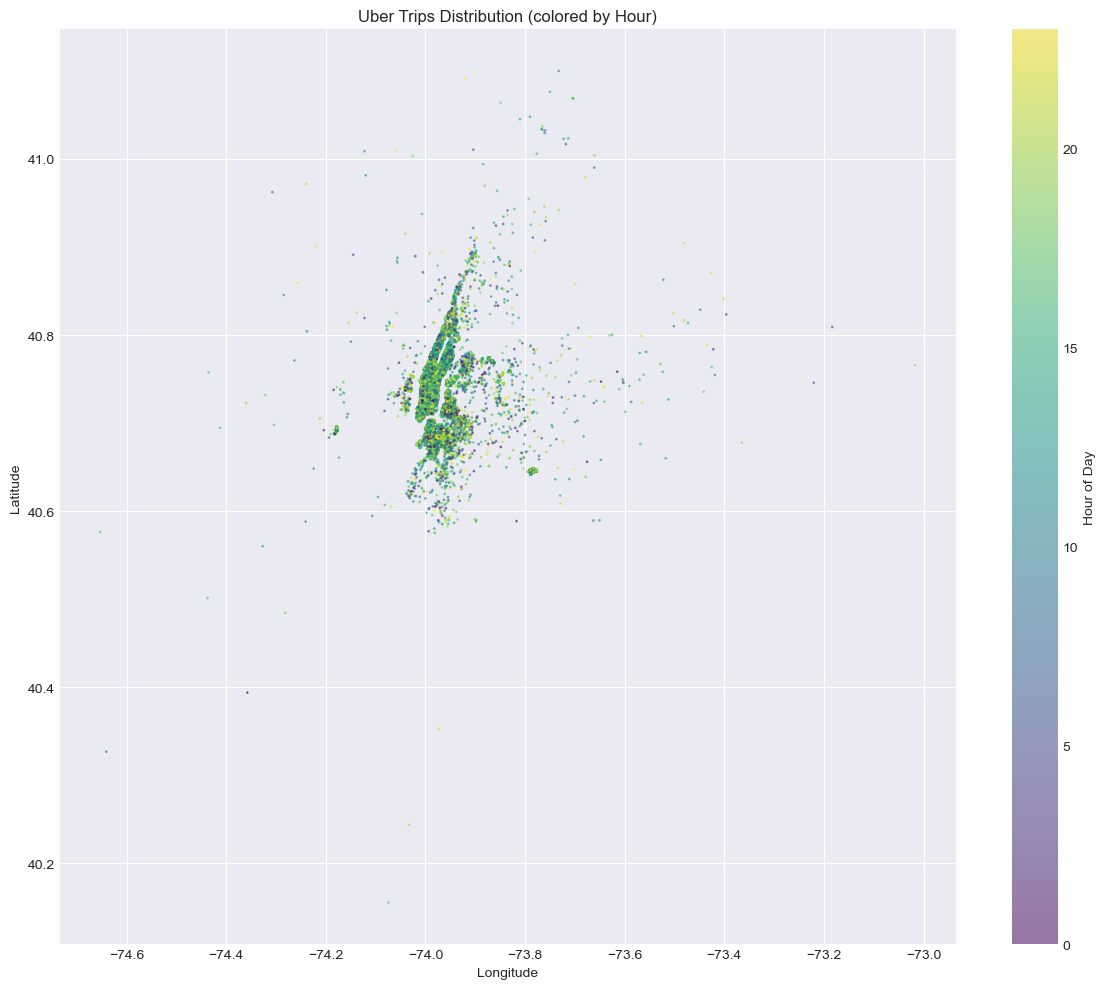

In [248]:
fig = px.scatter_mapbox(df.sample(10000), 
                        lat='Lat', 
                        lon='Lon',
                        hover_data=['Date/Time', 'Base'],
                        zoom=9,
                        height=600,
                        title='Uber Trips Distribution (Sample of 10,000 trips)')
fig.update_layout(mapbox_style="open-street-map")
fig.show()

fig, ax = plt.subplots(figsize=(12, 10))
sample_df = df.sample(20000)
scatter = ax.scatter(sample_df['Lon'], sample_df['Lat'], 
                     c=sample_df['Hour'], 
                     cmap='viridis', 
                     alpha=0.5, 
                     s=1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Uber Trips Distribution (colored by Hour)')
plt.colorbar(scatter, label='Hour of Day')
plt.tight_layout()
plt.show()

## 3. Data Preparation for Clustering

We are going to use a sample to calculate k (with whole dataset it takes ages)

In [260]:
sample_size = 50000
np.random.seed(42)
df_sample = df.sample(n=sample_size, random_state=42)

X = df_sample[['Lat', 'Lon']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Sample size: {len(df_sample):,} trips")
print(f"Feature shape: {X_scaled.shape}")

Sample size: 50,000 trips
Feature shape: (50000, 2)


## 4. Find Optimal K for K-Means

In [250]:
k_range = range(2, 10)
inertias = []
silhouette_scores = []
calinski_harabasz_scores = []

print("Testing different k values...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

    print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}, CH={calinski_harabasz_scores[-1]:.3f}")

Testing different k values...
k=2: Silhouette=0.647, CH=19363.992
k=2: Silhouette=0.647, CH=19363.992
k=3: Silhouette=0.402, CH=24992.401
k=3: Silhouette=0.402, CH=24992.401
k=4: Silhouette=0.412, CH=24066.054
k=4: Silhouette=0.412, CH=24066.054
k=5: Silhouette=0.428, CH=24218.264
k=5: Silhouette=0.428, CH=24218.264
k=6: Silhouette=0.440, CH=25933.081
k=6: Silhouette=0.440, CH=25933.081
k=7: Silhouette=0.460, CH=27451.743
k=7: Silhouette=0.460, CH=27451.743
k=8: Silhouette=0.464, CH=29206.793
k=8: Silhouette=0.464, CH=29206.793
k=9: Silhouette=0.418, CH=29789.305
k=9: Silhouette=0.418, CH=29789.305


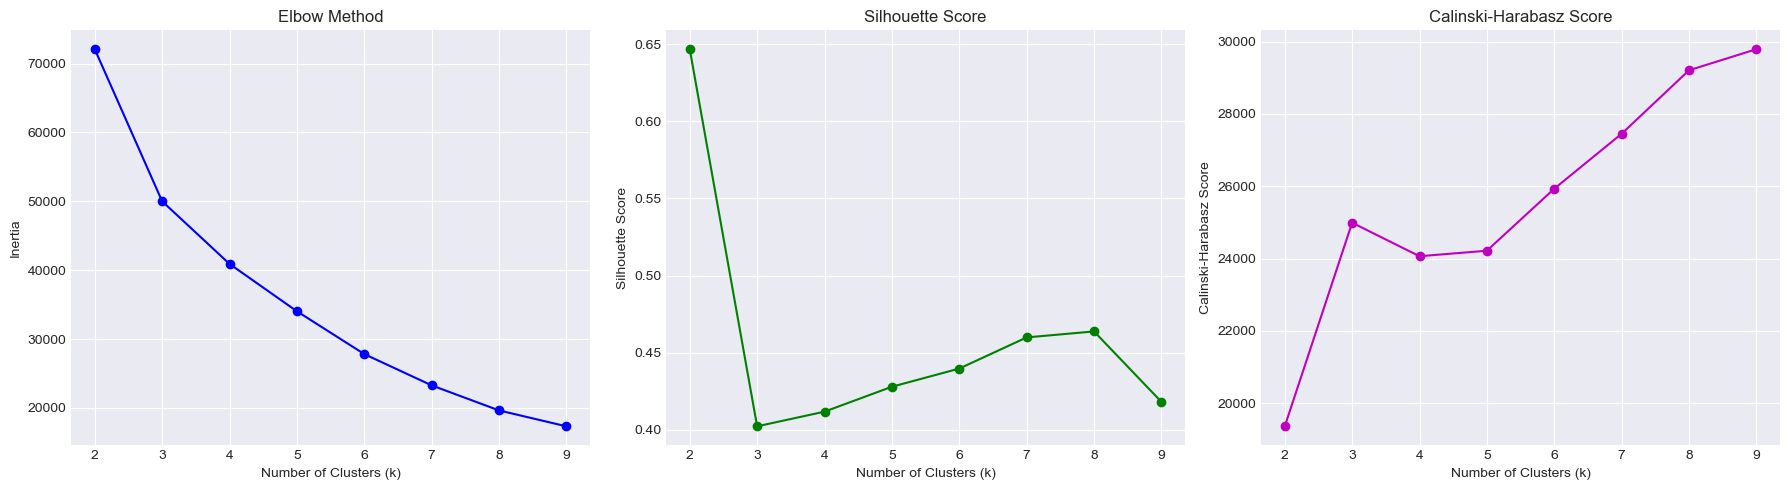

In [257]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(k_range, silhouette_scores, 'go-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score')
axes[1].grid(True)

axes[2].plot(k_range, calinski_harabasz_scores, 'mo-')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].set_title('Calinski-Harabasz Score')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [258]:
optimal_k = 8
print(f"Optimal k = {optimal_k}")

Optimal k = 8


## 5. Clustering Algorithms


### 5.1 K-Means Clustering

In [261]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_sample['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

kmeans_silhouette = silhouette_score(X_scaled, df_sample['KMeans_Cluster'])
kmeans_ch = calinski_harabasz_score(X_scaled, df_sample['KMeans_Cluster'])

print(f"K-Means Results:")
print(f"Clusters: {optimal_k}")
print(f"Silhouette: {kmeans_silhouette:.4f}")

K-Means Results:
Clusters: 8
Silhouette: 0.4638


### 5.2 DBSCAN Clustering

Now let's try DBSCAN which should work better for geographic data.

In [ ]:
from sklearn.cluster import DBSCAN


print(f"Feature shape: {X_scaled.shape}")

Feature shape: (50000, 2)


In [266]:
eps_values = [ 0.06, 0.07, 0.08]
min_samples_values = [10, 15, 20, 30]

print("Testing DBSCAN parameters...")
dbscan_results = []

for eps_val in eps_values:
    for min_samples_val in min_samples_values:
        dbscan_test = DBSCAN(eps=eps_val, min_samples=min_samples_val)
        labels_test = dbscan_test.fit_predict(X_scaled)
        
        n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
        n_noise_test = list(labels_test).count(-1)
        noise_pct = (n_noise_test / len(labels_test)) * 100
        
        if n_clusters_test > 1:
            mask_test = labels_test != -1
            if mask_test.sum() > 0:
                silhouette_test = silhouette_score(X_scaled[mask_test], labels_test[mask_test])
                
                dbscan_results.append({
                    'eps': eps_val,
                    'min_samples': min_samples_val,
                    'n_clusters': n_clusters_test,
                    'noise_pct': noise_pct,
                    'silhouette': silhouette_test
                })
                
                print(f"eps={eps_val:.2f}, min_samples={min_samples_val}: "
                      f"clusters={n_clusters_test}, noise={noise_pct:.1f}%, "
                      f"silhouette={silhouette_test:.4f}")

dbscan_results_df = pd.DataFrame(dbscan_results)
print("\nBest configurations:")
best_results = dbscan_results_df[dbscan_results_df['noise_pct'] < 15].nlargest(5, 'silhouette')
if len(best_results) > 0:
    print(best_results.to_string(index=False))
else:
    print("No configs with noise < 15%, showing top 5 by silhouette:")
    print(dbscan_results_df.nlargest(5, 'silhouette').to_string(index=False))

Testing DBSCAN parameters...
eps=0.06, min_samples=10: clusters=50, noise=4.7%, silhouette=-0.0836
eps=0.06, min_samples=15: clusters=38, noise=6.0%, silhouette=-0.0186
eps=0.06, min_samples=20: clusters=36, noise=6.9%, silhouette=-0.0295
eps=0.06, min_samples=30: clusters=21, noise=9.9%, silhouette=0.0062
eps=0.07, min_samples=10: clusters=38, noise=4.1%, silhouette=0.0787
eps=0.07, min_samples=15: clusters=28, noise=5.1%, silhouette=0.0848
eps=0.07, min_samples=20: clusters=26, noise=5.9%, silhouette=0.0102
eps=0.07, min_samples=30: clusters=25, noise=8.1%, silhouette=0.0068
eps=0.08, min_samples=10: clusters=29, noise=3.7%, silhouette=0.0943
eps=0.08, min_samples=15: clusters=25, noise=4.5%, silhouette=0.1409
eps=0.08, min_samples=20: clusters=22, noise=5.3%, silhouette=0.0954
eps=0.08, min_samples=30: clusters=22, noise=6.6%, silhouette=0.0131

Best configurations:
 eps  min_samples  n_clusters  noise_pct  silhouette
0.08           15          25      4.500    0.140864
0.08        

In [267]:
best_config = dbscan_results_df[dbscan_results_df['noise_pct'] < 10].nlargest(1, 'silhouette').iloc[0]

best_eps = best_config['eps']
best_min_samples = int(best_config['min_samples'])

print(f"Selected: eps={best_eps}, min_samples={best_min_samples}")

Selected: eps=0.08, min_samples=15


In [268]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df_sample['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

mask = df_sample['DBSCAN_Cluster'] != -1
n_clusters_dbscan = len(set(df_sample['DBSCAN_Cluster'])) - (1 if -1 in df_sample['DBSCAN_Cluster'].values else 0)
n_noise = (df_sample['DBSCAN_Cluster'] == -1).sum()

if mask.sum() > 0 and n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(X_scaled[mask], df_sample.loc[mask, 'DBSCAN_Cluster'])
    dbscan_ch = calinski_harabasz_score(X_scaled[mask], df_sample.loc[mask, 'DBSCAN_Cluster'])
   
else:
    dbscan_silhouette = 0
    dbscan_ch = 0
    dbscan_db = float('inf')

print(f"\nDBSCAN Results:")
print(f"Clusters: {n_clusters_dbscan}")
print(f"Noise: {n_noise} ({n_noise/len(df_sample)*100:.1f}%)")
print(f"Silhouette: {dbscan_silhouette:.4f}")
print(f"Calinski-Harabasz: {dbscan_ch:.2f}")


DBSCAN Results:
Clusters: 25
Noise: 2250 (4.5%)
Silhouette: 0.1409
Calinski-Harabasz: 4068.53


### 5.3 Algorithm Comparison

In [269]:
print("Comparison on same sample:")
print(f"\nK-Means: Silhouette={kmeans_silhouette:.4f}, CH={kmeans_ch:.2f}")
print(f"DBSCAN: Silhouette={dbscan_silhouette:.4f}, CH={dbscan_ch:.2f}, DB={dbscan_db:.4f}")

print("K-Means Results:")
print(f"  Silhouette: {kmeans_silhouette:.4f}")
print(f"  Calinski-Harabasz: {kmeans_ch:.2f}")
print(f"  Davies-Bouldin: {kmeans_db:.4f}")

print("\nDBSCAN Results:")
print(f"  Silhouette: {dbscan_silhouette:.4f}")
print(f"  Calinski-Harabasz: {dbscan_ch:.2f}")
print(f"  Davies-Bouldin: {dbscan_db:.4f}")

Comparison on same sample:

K-Means: Silhouette=0.4638, CH=29206.79
DBSCAN: Silhouette=0.1409, CH=4068.53, DB=0.4528
K-Means Results:
  Silhouette: 0.4638
  Calinski-Harabasz: 29206.79
  Davies-Bouldin: 0.6530

DBSCAN Results:
  Silhouette: 0.1409
  Calinski-Harabasz: 4068.53
  Davies-Bouldin: 0.4528


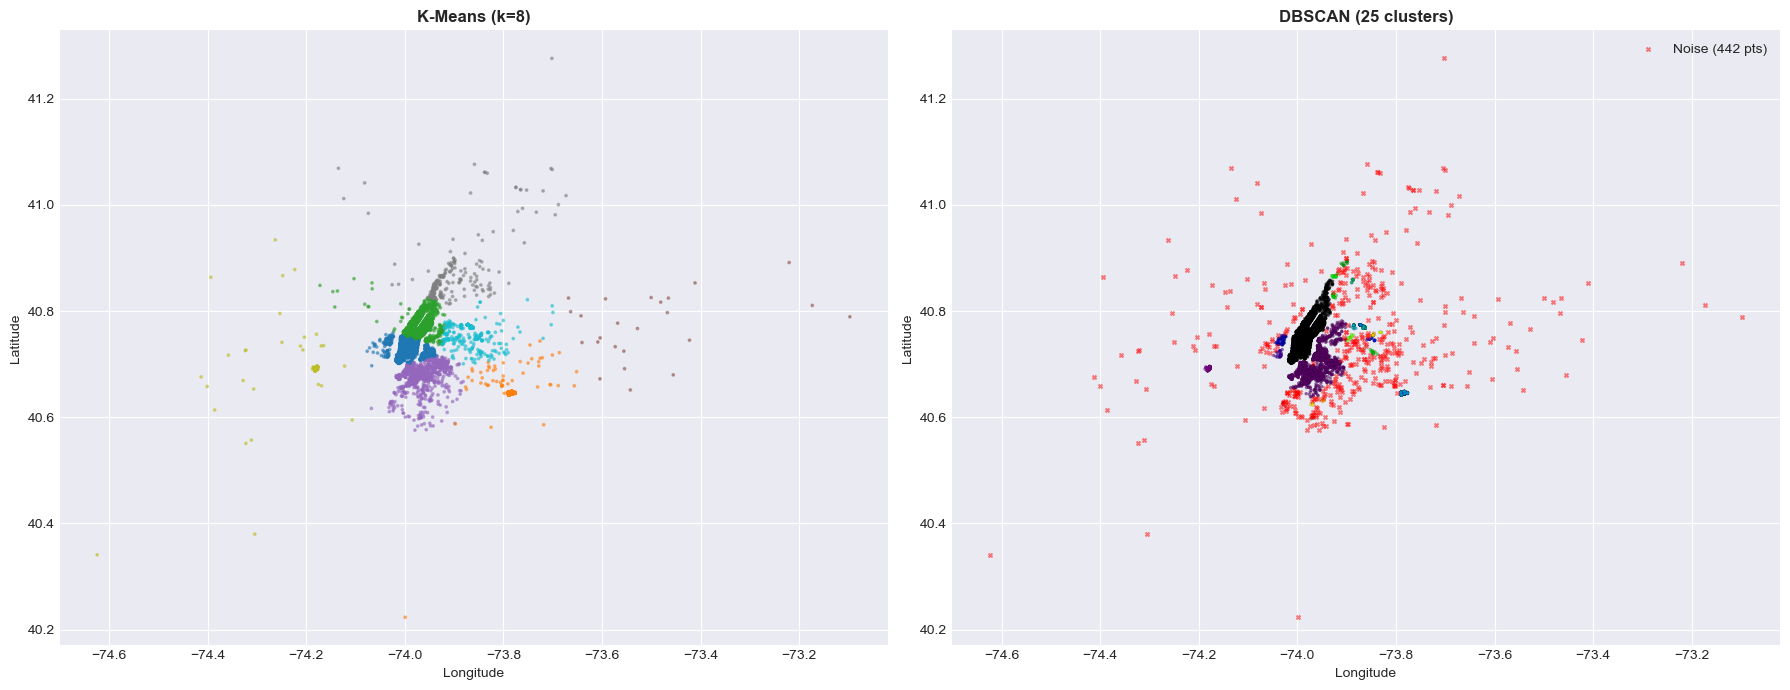

In [270]:
# Side-by-side visualization
sample_viz = df_sample.sample(n=10000, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-Means
axes[0].scatter(sample_viz['Lon'], sample_viz['Lat'], 
               c=sample_viz['KMeans_Cluster'], cmap='tab10', alpha=0.5, s=3)
axes[0].set_title(f'K-Means (k={optimal_k})', fontweight='bold')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# DBSCAN
cluster_mask = sample_viz['DBSCAN_Cluster'] != -1
axes[1].scatter(sample_viz[cluster_mask]['Lon'], sample_viz[cluster_mask]['Lat'], 
               c=sample_viz[cluster_mask]['DBSCAN_Cluster'], cmap='nipy_spectral', alpha=0.6, s=5, edgecolors='black', linewidths=0.1)
noise_viz = sample_viz[~cluster_mask]
if len(noise_viz) > 0:
    axes[1].scatter(noise_viz['Lon'], noise_viz['Lat'], 
                   c='red', alpha=0.5, s=8, marker='x', label=f'Noise ({len(noise_viz)} pts)')
axes[1].set_title(f'DBSCAN ({n_clusters_dbscan} clusters)', fontweight='bold')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Analyze DBSCAN Clusters

In [272]:
sample_viz_map = df_sample[df_sample['DBSCAN_Cluster'] != -1].sample(n=min(5000, len(df_sample[df_sample['DBSCAN_Cluster'] != -1])), random_state=42)

fig = px.scatter_mapbox(sample_viz_map, 
                        lat='Lat', 
                        lon='Lon',
                        color='DBSCAN_Cluster',
                        hover_data=['Hour', 'DayOfWeekName'],
                        zoom=9,
                        height=700,
                        title=f'DBSCAN Clustering Results',
                        color_continuous_scale='Rainbow')
fig.update_layout(mapbox_style="open-street-map")
fig.show()

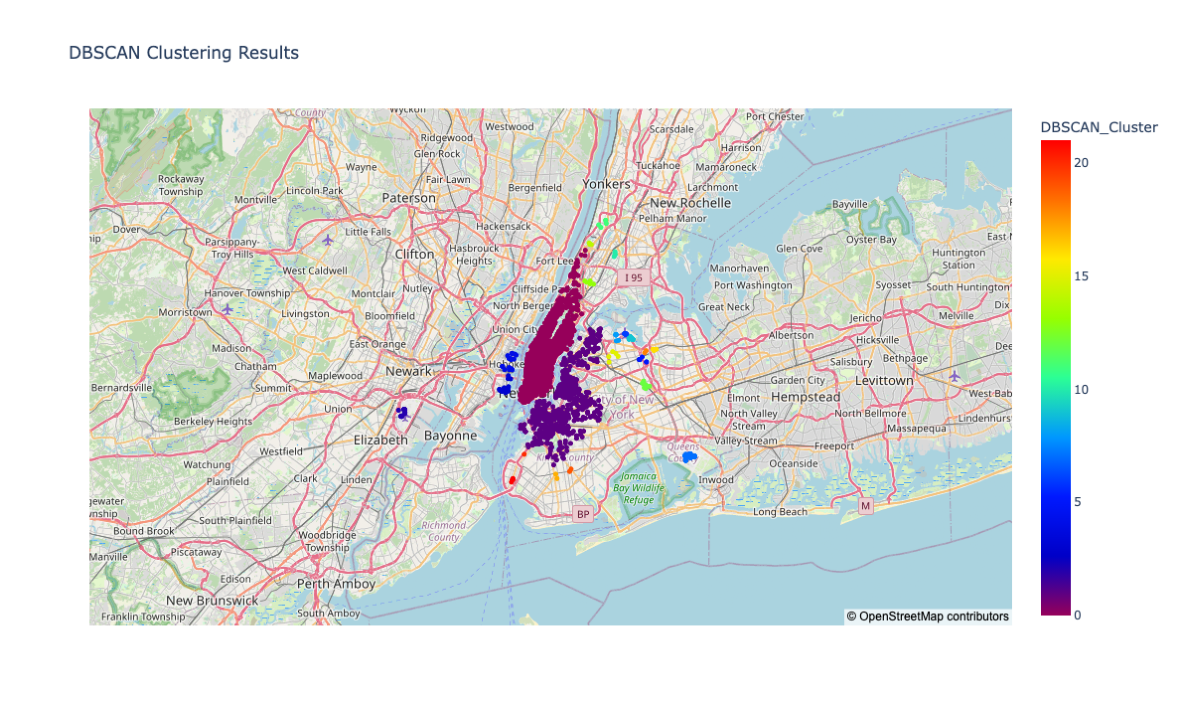

In [281]:
img = mpimg.imread('dbscan.png')
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')  
plt.tight_layout()
plt.show()

## 7. Hourly Patterns by Cluster

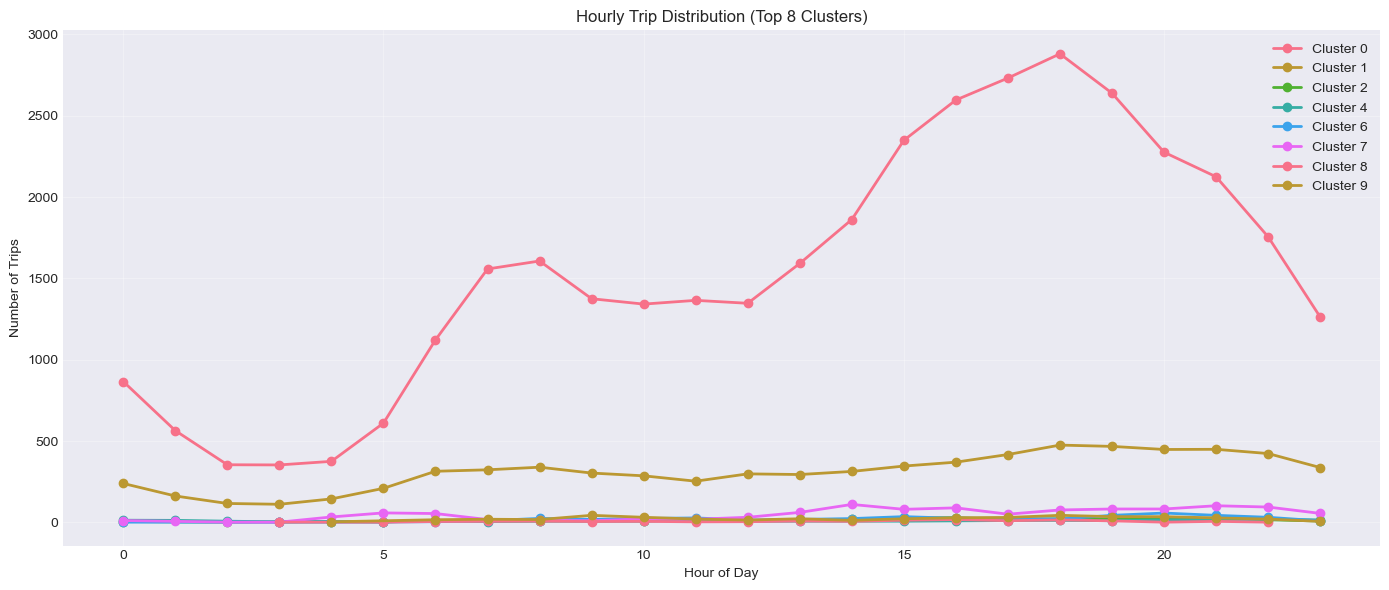

In [276]:
df_analysis = df_sample[df_sample['DBSCAN_Cluster'] != -1].copy()

hourly_clusters = df_analysis.groupby(['DBSCAN_Cluster', 'Hour']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(14, 6))
top_clusters = df_analysis['DBSCAN_Cluster'].value_counts().head(8).index
for cluster in sorted(top_clusters):
    cluster_data = hourly_clusters[hourly_clusters['DBSCAN_Cluster'] == cluster]
    ax.plot(cluster_data['Hour'], cluster_data['Count'], marker='o', label=f'Cluster {cluster}', linewidth=2)

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Trips')
ax.set_title('Hourly Trip Distribution (Top 8 Clusters)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Weekly Patterns

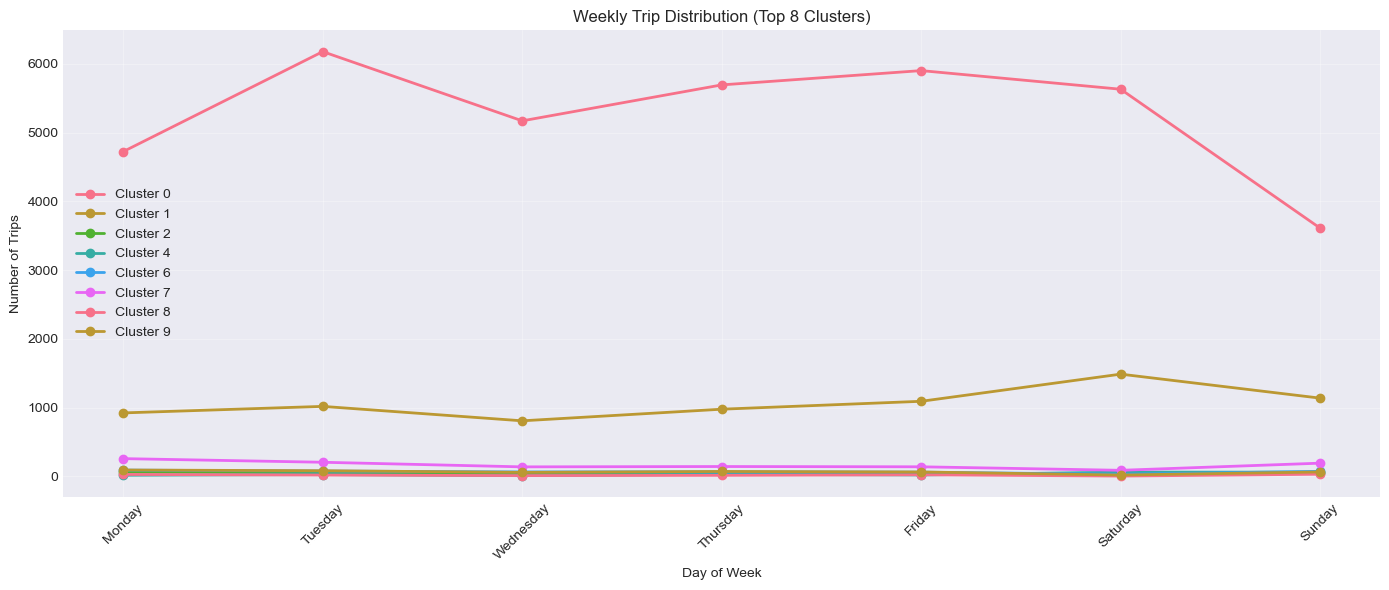

In [278]:
dow_clusters = df_analysis.groupby(['DBSCAN_Cluster', 'DayOfWeek', 'DayOfWeekName']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(14, 6))
for cluster in sorted(top_clusters):
    cluster_data = dow_clusters[dow_clusters['DBSCAN_Cluster'] == cluster].sort_values('DayOfWeek')
    ax.plot(cluster_data['DayOfWeekName'], cluster_data['Count'], marker='o', 
            label=f'Cluster {cluster}', linewidth=2)

ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Trips')
ax.set_title('Weekly Trip Distribution (Top 8 Clusters)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

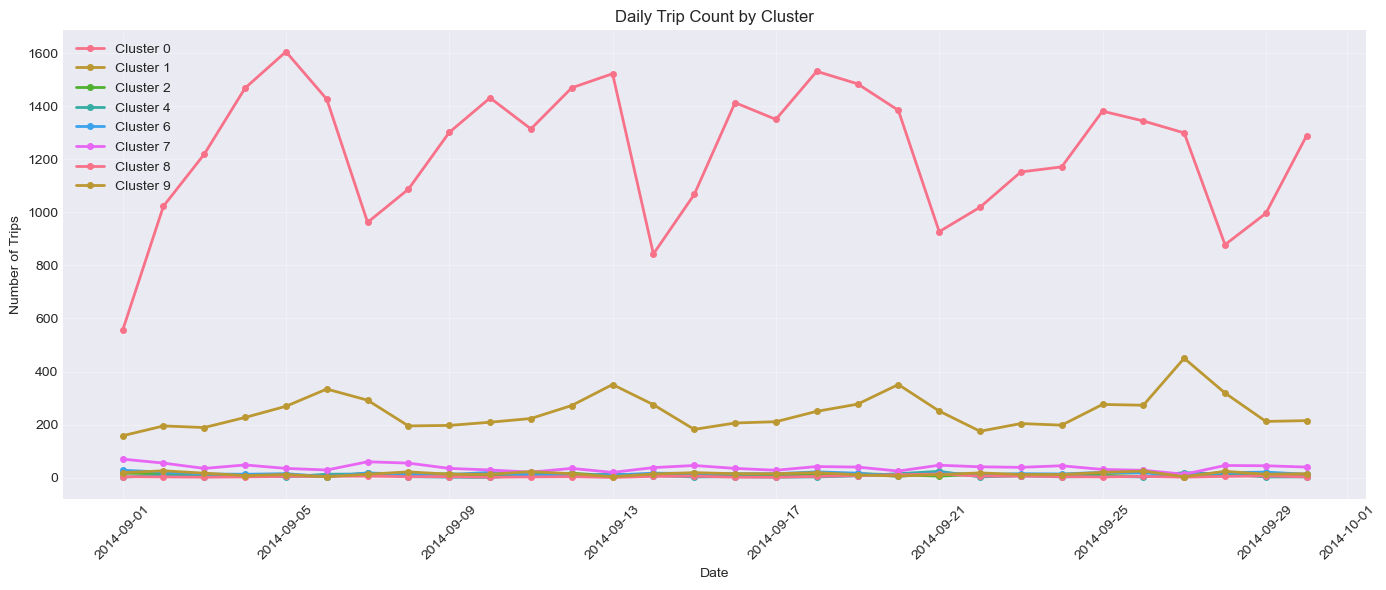

In [279]:

daily_trends = df_analysis.groupby(['Date', 'DBSCAN_Cluster']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(14, 6))
for cluster in sorted(top_clusters):
    cluster_data = daily_trends[daily_trends['DBSCAN_Cluster'] == cluster]
    ax.plot(cluster_data['Date'], cluster_data['Count'], marker='o', 
            label=f'Cluster {cluster}', linewidth=2, markersize=4)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Trips')
ax.set_title('Daily Trip Count by Cluster')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()